# The Truth

In [ ]:

from os import getcwd
from os.path import join
from re import findall, sub
from string import punctuation

import matplotlib.pyplot as plt
import spacy
from nltk.stem.porter import PorterStemmer
from pandas import DataFrame, read_json
from sklearn.ensemble import AdaBoostClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from spacy.lang.en.stop_words import STOP_WORDS

data_directory = join(getcwd(), 'data')


# Brief description of the problem and data (5 pts) 

**What problem do you solve?**

The incorporation of sarcasm into news headlines has become increasingly prevalent, posing challenges for individuals with Asperger's syndrome, I have it.
It is hard for me to catch the jokes. While sarcasm can add flair and catch attention, its subjective nature can lead to misinterpretation, especially among those with Asperger's, who may struggle with understanding nuances in communication.
News outlets often use sarcasm to inject humor or convey skepticism, but for individuals with Asperger's, who rely heavily on literal interpretation, this can lead to confusion or misunderstanding of the intended message.



**What ML approach do you use, or what methods does your app use?**

- AdaBoost (Utilized to train models that classify news headlines as sarcastic or non-sarcastic)
- Decision Tree (Employed to identify key linguistic features indicative of sarcasm in news headlines)
- spaCy (NLP library, offers robust tools for tokenization, part-of-speech tagging, and dependency parsing)

### Load Data

Download the data from https://www.kaggle.com/datasets/rmisra/news-headlines-dataset-for-sarcasm-detection/data/

In [ ]:
class Data:
    def __init__(self):
        self.dataset: DataFrame = read_json(join(data_directory, 'Sarcasm_Headlines_Dataset.json'), lines=True)
        self.dataset_v2: DataFrame = read_json(join(data_directory, 'Sarcasm_Headlines_Dataset_v2.json'), lines=True)
        self.x_train = None
        self.x_test = None
        self.y_train = None
        self.y_test = None
        self.x_train_transform = None
        self.x_test_transform = None
        spacy.require_gpu()
        self.spacy = spacy.load("en_core_web_sm")

    def print_stats_of_datasets(self):
        print_title('Head')
        print(self.dataset.head())
        print_title('Info')
        print(self.dataset.info())
        print_title('Sample')
        print(self.dataset.sample(3))
        print_title('Duplicates')
        print(self.dataset['headline'].duplicated().sum())

    def display_chart_of_top_words(self):
        words = self.dataset['headline'].str.split().explode()
        word_counts = words.value_counts()
        top_20_words = word_counts.head(20)
        top_20_words.plot(kind='bar', figsize=(10, 6), color='skyblue')
        plt.title('Top 20 Most Frequent Words in Headlines')
        plt.xlabel('Words')
        plt.ylabel('Frequency')
        plt.xticks(rotation=45)
        plt.show()

    def clean_dataset(self):
        # Drop Duplicates
        self.dataset = self.dataset.drop(self.dataset[self.dataset['headline'].duplicated()].index, axis=0)

        def clean_text(text):
            if isinstance(text, str):  # Check if the input is a string
                temp = text.lower()
                temp = sub('\d', '', temp)
                temp = sub('<[^>]*>', '', temp)
                emojis = findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', temp)
                temp = sub('[\W]+', ' ', temp) + ' '.join(emojis).replace('-', '')
                temp = sub('[{}]'.format(punctuation), '', temp)
                return temp.strip()
            else:
                return text

        # Remove special characters
        self.dataset['headline'] = self.dataset['headline'].apply(lambda x: clean_text(x))

    def transform(self):
        stopwords = list(STOP_WORDS)
        porter = PorterStemmer()

        def text_tokenizer(text):
            words_after_stem = [porter.stem(word) for word in text.split()]
            return [word for word in words_after_stem if word not in stopwords and len(word) > 2]

        vectorizer = CountVectorizer(tokenizer=text_tokenizer, binary=True, token_pattern=None)

        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(self.dataset['headline'],
                                                                                self.dataset['is_sarcastic'],
                                                                                test_size=0.3)

        self.x_train = vectorizer.fit_transform(self.x_train)
        self.x_test = vectorizer.transform(self.x_test)

In [3]:
# Intializing the Data class loads the data from file
data = Data()

In [4]:
def print_title(text):
    print(f"\033[1;31mDataset {text}\033[0m")

# Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data

## Inspect

In [5]:
data.print_stats_of_datasets()

Dataset Head
                                        article_link  \
0  https://www.huffingtonpost.com/entry/versace-b...   
1  https://www.huffingtonpost.com/entry/roseanne-...   
2  https://local.theonion.com/mom-starting-to-fea...   
3  https://politics.theonion.com/boehner-just-wan...   
4  https://www.huffingtonpost.com/entry/jk-rowlin...   

                                            headline  is_sarcastic  
0  former versace store clerk sues over secret 'b...             0  
1  the 'roseanne' revival catches up to our thorn...             0  
2  mom starting to fear son's web series closest ...             1  
3  boehner just wants wife to listen, not come up...             1  
4  j.k. rowling wishes snape happy birthday in th...             0  
Dataset Info
<class 'pandas.core.frame.DataFrame'>
Index: 26709 entries, 0 to 26708
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   article_link  26709 non-null  o

### Visualize

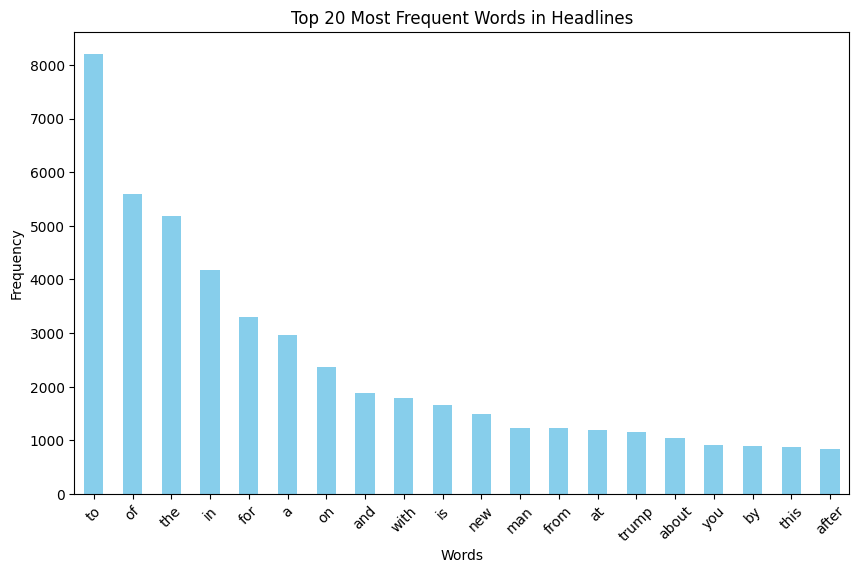

In [6]:
data.display_chart_of_top_words()

## Clean the Data

In [7]:
data.clean_dataset()

# Classification

In [8]:
class Classifier:
    def __init__(self, x_train, x_test, y_train, y_test, classifier, name):
        self.name = name
        self.classifier = classifier
        self.classifier = DecisionTreeClassifier(max_depth=5)
        self.prediction = None
        self.x_train = x_train
        self.x_test = x_test
        self.y_train = y_train
        self.y_test = y_test

    def train(self):
        self.classifier.fit(self.x_train, self.y_train)
        self.prediction = self.classifier.predict(self.x_test)

    def print_metrics(self):
        print_title(self.name)
        print(classification_report(self.y_test, self.prediction))

    def display_matrix_display(self):
        confusion_matrix_ = confusion_matrix(self.y_test, self.prediction)
        fig, ax = plt.subplots(figsize=(5, 5))
        display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_, display_labels=['sarcastic',
                                                                                             'non-sarcastic'])
        display.plot(ax=ax, cmap=plt.cm.RdBu)
        plt.suptitle(self.name)
        plt.show()


class DecisionTree(Classifier):
    def __init__(self, x_train, x_test, y_train, y_test):
        super().__init__(x_train, x_test, y_train, y_test, DecisionTreeClassifier(max_depth=5), 'Decision Tree')


class AdaBoost(Classifier):
    def __init__(self, x_train, x_test, y_train, y_test):
        super().__init__(x_train, x_test, y_train, y_test, AdaBoostClassifier(), 'AdaBoost')


In [9]:
## Transform Data

In [10]:
data.transform()

## Train, Predict, Metrics

In [11]:
decision_tree = DecisionTree(data.x_train, data.x_test, data.y_train, data.y_test)

In [12]:
decision_tree.train()

In [13]:
decision_tree.print_metrics()

Dataset Decision Tree
              precision    recall  f1-score   support

           0       0.60      0.97      0.74      4477
           1       0.82      0.19      0.31      3504

    accuracy                           0.63      7981
   macro avg       0.71      0.58      0.53      7981
weighted avg       0.70      0.63      0.55      7981



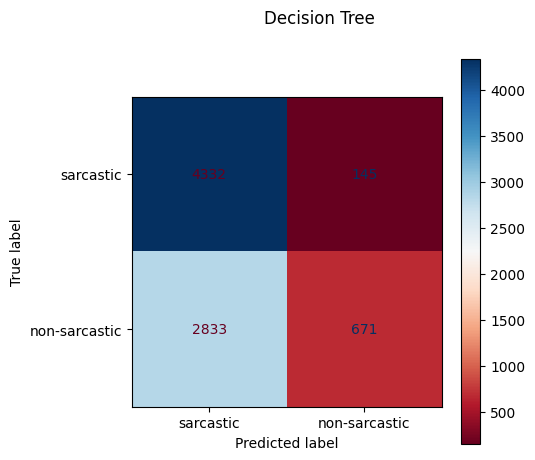

In [14]:
decision_tree.display_matrix_display()

In [15]:
ada_boost = AdaBoost(data.x_train, data.x_test, data.y_train, data.y_test)

In [16]:
ada_boost.train()

In [17]:
ada_boost.print_metrics()

Dataset AdaBoost
              precision    recall  f1-score   support

           0       0.60      0.97      0.74      4477
           1       0.82      0.19      0.31      3504

    accuracy                           0.63      7981
   macro avg       0.71      0.58      0.53      7981
weighted avg       0.70      0.63      0.55      7981



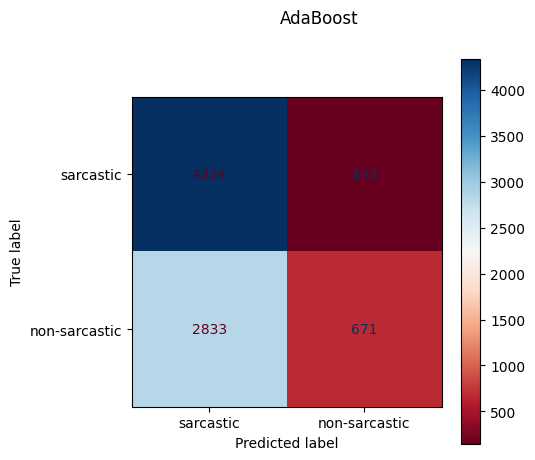

In [18]:
ada_boost.display_matrix_display()